In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import PIL
from PIL import Image


# torch
import torch

# key_dynam
from key_dynam.utils.utils import get_project_root, load_yaml
from key_dynam.dataset.drake_sim_episode_reader import DrakeSimEpisodeReader
from key_dynam.utils import transform_utils
from key_dynam.utils import drake_image_utils

# pdc
from dense_correspondence.dataset.dynamic_drake_sim_dataset import DynamicDrakeSimDataset
from dense_correspondence.correspondence_tools.correspondence_finder import reproject_pixels
from dense_correspondence.correspondence_tools import correspondence_plotter
from dense_correspondence.correspondence_tools.correspondence_finder import compute_correspondence_data, pad_correspondence_data
from dense_correspondence_manipulation.utils.utils import getDenseCorrespondenceSourceDir, set_cuda_visible_devices
import dense_correspondence.loss_functions.utils as loss_utils
import dense_correspondence_manipulation.utils.utils as pdc_utils
import dense_correspondence_manipulation.utils.visualization as vis_utils

GPU_LIST = [1]
set_cuda_visible_devices(GPU_LIST)

setting CUDA_VISIBLE_DEVICES =  1,


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: _DrakeImportWarning: 
You may have already (directly or indirectly) imported `torch` which uses
`RTLD_GLOBAL`. Using `RTLD_GLOBAL` may cause symbol collisions which manifest
themselves in bugs like "free(): invalid pointer". Please consider importing
`pydrake` (and related C++-wrapped libraries like `cv2`, `open3d`, etc.)
*before* importing `torch`. For more details, see:
https://github.com/pytorch/pytorch/issues/3059#issuecomment-534676459



episode name: 2019-12-03-22-49-25-126451_idx_0
episode._non_image_data.keys() dict_keys(['name', 'config', 'trajectory', 'metadata', 'hdf5_file'])
data_a.keys() dict_keys(['rgb', 'label', 'mask', 'depth_float32', 'depth_int16', 'K', 'T_world_camera', 'camera_name', 'idx'])
label.dtype int16


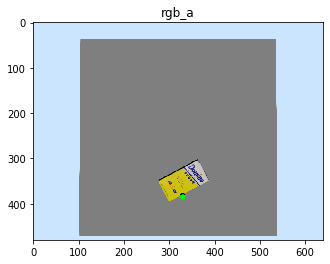

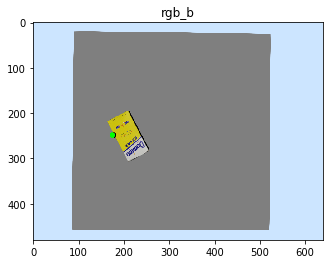

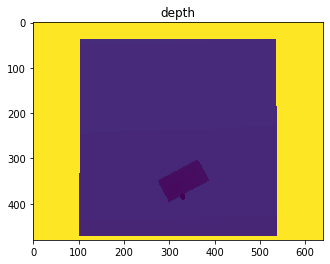

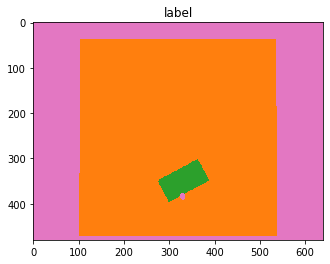

Text(0.5, 1.0, 'mask')

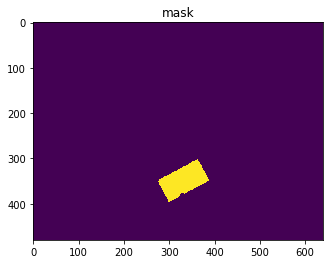

In [3]:
DATASET_NAME = "2019-11-26-00-03-48-223155"
DATASET_NAME = "top_down_same_view"
DATASET_NAME = "top_down_rotated"

dataset_root = os.path.join(get_project_root(), "data/dev/experiments/05/data", DATASET_NAME)

multi_episode_dict = DrakeSimEpisodeReader.load_dataset(dataset_root)
# make pdc dataset now

# placeholder for now
config_file = os.path.join(getDenseCorrespondenceSourceDir(), 
                           'config/dense_correspondence/global/drake_sim_dynamic.yaml')
config = load_yaml(config_file)
dataset = DynamicDrakeSimDataset(config, multi_episode_dict, phase="train")

episode_name = list(multi_episode_dict.keys())[0]
print("episode name:", episode_name)

idx = 0
episode = multi_episode_dict[episode_name]
print("episode._non_image_data.keys()", episode._non_image_data.keys())

camera_names = list(episode.camera_names)
camera_name_a = camera_names[0]
camera_name_b = camera_names[1]

# camera_name_a = "camera_1_top_down"
# camera_name_b = "camera_2_top_down_rotated"
data_a = episode.get_image_data(camera_name_a, idx)
data_b = episode.get_image_data(camera_name_b, idx)

print("data_a.keys()", data_a.keys())

# plot RGB
plt.figure()
plt.imshow(data_a['rgb'])
plt.title('rgb_a')

# plot RGB b
plt.figure()
plt.imshow(data_b['rgb'])
plt.title('rgb_b')

# depth
depth_float32 = data_a['depth_float32']
depth_float32 = np.clip(depth_float32, 0, 2)
plt.figure()
plt.imshow(depth_float32)
plt.title("depth")

# label
label = data_a['label']
label_cp = np.copy(label)
print("label.dtype", label.dtype)
color_label = drake_image_utils.colorize_labels(label_cp)
plt.figure()
plt.imshow(color_label)
plt.title('label')
plt.show()

# mask
mask = data_a['mask']
plt.figure()
plt.imshow(mask)
plt.title('mask')

In [4]:
# load network

# model_name = "2019-12-03-21-25-46-128603_top_down_same_view"
# model_name = "2019-12-03-22-51-17-805212_top_down_rotated"
model_name = "2019-12-03-23-40-30-486661_top_down_rotated_sigma_5"
network_folder = os.path.join(get_project_root(), "data/dev/experiments/05/trained_models", model_name)

epoch = 16
model_file = os.path.join(network_folder, "net_dy_epoch_%d_iter_0_model.pth" %(epoch))
model = torch.load(model_file)
model.cuda()
model = model.eval()

In [10]:
pdc_utils.reset_random_seed()
device = next(model.parameters()).device

print("device:")
idx = 30

MODEL_ENABLED = True

with torch.no_grad():

    # indices
    b = 0
    n = 10

    data = dataset._getitem(episode, 
                            idx,
                            camera_name_a=camera_name_a, 
                            camera_name_b=camera_name_b)
    data_a = data['data_a']
    rgb_tensor_a = data_a['rgb_tensor'].to(device).unsqueeze(0)
    rgb_tensor_b = data['data_b']['rgb_tensor'].to(device).unsqueeze(0)
    rgb_a = data_a['rgb']
    uv_a = data['matches']['uv_a'].unsqueeze(0).to(device) # [B, 2, N]
    uv_b = data['matches']['uv_b'].unsqueeze(0).to(device) # [B, 2, N]
    valid = data['matches']['valid'].unsqueeze(0).to(device) # [B, N]
#     uv_a = uv_a[:,]

    # [1,D,H,W]
    if MODEL_ENABLED:
        out_a = model.forward(rgb_tensor_a)
        des_img_a = out_a['descriptor_image']
        
        out_b = model.forward(rgb_tensor_b)
        des_img_b = out_b['descriptor_image']

    # uv
    uv = uv_b[b, :, n]
    uv_gt = uv
    u = uv[0]
    v = uv[1]
    rgb_w_reticle = np.copy(data['data_b']['rgb'])
    label_color = [0, 255, 0]
    vis_utils.draw_reticle(rgb_w_reticle, u, v, label_color)

    sz = 2
    figsize = (6.4*sz, 4.8*sz)
#     plt.figure(figsize=figsize)
#     plt.imshow(rgb)
#     plt.title("rgb w/ reticle")

    sigma = 1
    heatmap_type = "exp"

    if MODEL_ENABLED:
        # des_a
        # [B,N,D]
        des_a = pdc_utils.index_into_batch_image_tensor(des_img_a, uv_a).permute([0,2,1])

        # get heatmap and plot it
        heatmap_pred = loss_utils.compute_heatmap_from_descriptors(des_a,
                                                               des_img_b,
                                                               sigma=sigma,
                                                               type=heatmap_type)
        
        # compute best match
        B = rgb_tensor_a.shape[0]
        D = rgb_tensor_a.shape[1]
        H = rgb_tensor_a.shape[2]
        W = rgb_tensor_a.shape[3]
        N = uv_a.shape[2]

        # [B, N, D, H, W]
        expand_batch_des_a = pdc_utils.expand_descriptor_batch(des_a, H, W)
        expand_des_img_b = pdc_utils.expand_image_batch(des_img_b, N)

        # [B, N, H, W]
        norm_diff = (expand_batch_des_a - expand_des_img_b).norm(p=2, dim=2)

        best_match_dict = pdc_utils.find_pixelwise_extreme(norm_diff, type="min")
        
        # [B, N, 2]
        best_match_indices = best_match_dict['indices']
        uv_best_match = best_match_indices[b, n, :]
        pixel_diff = (uv_best_match - uv_gt).type(torch.float)
        
        print("pixel_error", torch.norm(pixel_diff))
        
        # draw
        label_color = [255, 0, 0]
        vis_utils.draw_reticle(rgb_w_reticle, uv_best_match[0], uv_best_match[1], label_color)
        print("best_match_indices.shape", best_match_indices.shape)
        
        
        # [B, N, 2]
        uv_b_pred = best_match_dict['indices']
        uv_b_gt = uv_b.permute([0, 2, 1])
        pixel_diff = (uv_b_pred - uv_b_gt).type(torch.float)

        # [B, N]
        pixel_error = torch.norm(pixel_diff, dim=2)

        # [M, 2]
        pixel_error_valid = pdc_utils.extract_valid(pixel_error, valid)

        avg_pixel_error = torch.mean(pixel_error_valid)
        median_pixel_error = torch.median(pixel_error_valid)
        
        print("avg_pixel_error", avg_pixel_error)
        print("median_pixel_error", median_pixel_error)



device:
pixel_error tensor(13.4164, device='cuda:0')
best_match_indices.shape torch.Size([1, 276, 2])
avg_pixel_error tensor(8.3972, device='cuda:0')
median_pixel_error tensor(6.7082, device='cuda:0')


(480, 640)
np.max(heatmap_pred) 0.78822947
np.min(heatmap_pred) 0.0


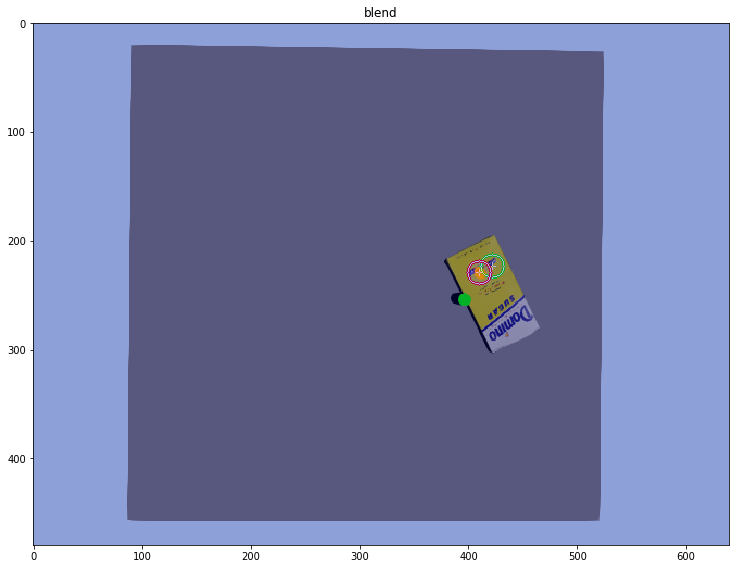

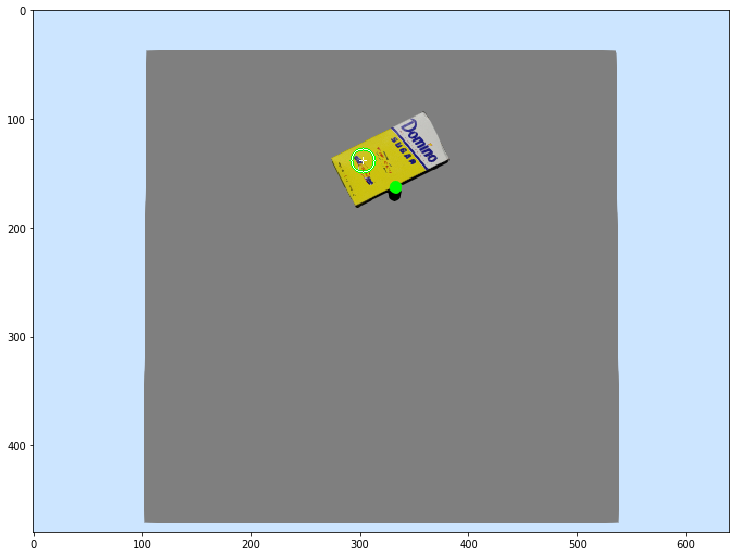

In [11]:
heatmap_pred_np = heatmap_pred.cpu().numpy()[b, n]
print(heatmap_pred_np.shape)
print("np.max(heatmap_pred)", np.max(heatmap_pred_np))
print("np.min(heatmap_pred)", np.min(heatmap_pred_np))

# plt.figure(figsize=figsize)
# plt.imshow(heatmap_pred_np)
# plt.title("heatmap")

# get colormap
colormap = vis_utils.colormap_from_heatmap(heatmap_pred_np, normalize=True)
# plt.figure(figsize=figsize)
# plt.imshow(colormap)
# plt.title("colormap")

colormap_PIL = Image.fromarray(colormap, mode='RGB')
rgb_PIL = Image.fromarray(rgb_w_reticle, mode='RGB')

alpha = 0.3
blend = Image.blend(rgb_PIL, colormap_PIL, alpha)
plt.figure(figsize=figsize)
plt.imshow(blend)
plt.title("blend")

rgb_a = np.copy(data['data_a']['rgb'])
vis_utils.draw_reticle(rgb_a, uv_a[b, 0, n], uv_a[b, 1, n], label_color=[0, 255, 0])
plt.figure(figsize=figsize)
plt.imshow(rgb_a)